# Пример работы инференса

In [7]:
import numpy as np
import tritonclient.http as httpclient
import cv2
import base64
import matplotlib.pyplot as plt
import json

### Подключаемся к инференсу

In [2]:
predictor_host = "0.0.0.0:8000"
triton_client = httpclient.InferenceServerClient(url=predictor_host, verbose=False)

### Считываем и кодируем картинки

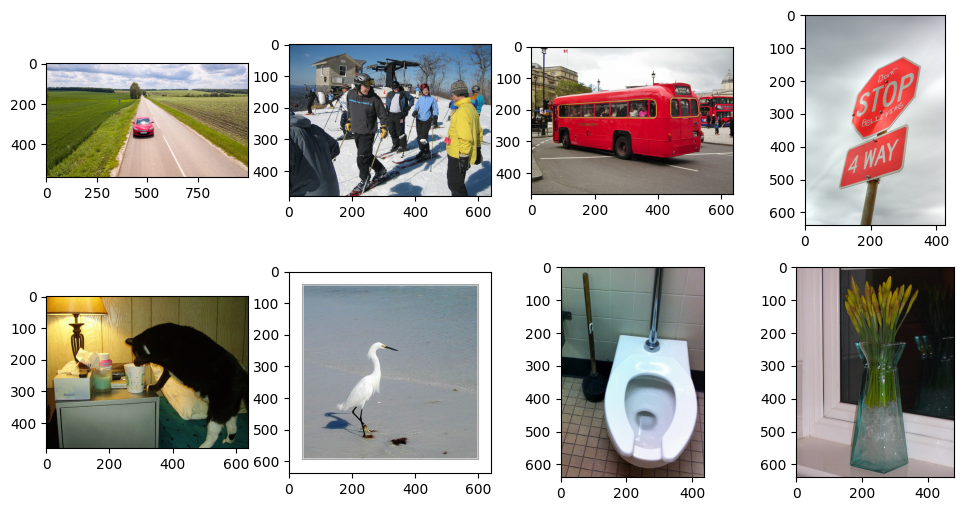

In [3]:
images = []
images_base64 = []
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    image = cv2.imread(f"test_images/{i}.jpg")
    retval, buffer = cv2.imencode('.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    base64_image = base64.b64encode(buffer).decode('utf-8')
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i%2][i//2].imshow(images[i])
    images_base64.append([base64_image])
plt.show()

### Делаем запрос к инференсу

In [4]:
np_data = np.array(images_base64, dtype=object)
inference_request = [httpclient.InferInput("IMAGE_BASE64", np_data.shape, "BYTES")]
inference_request[0].set_data_from_numpy(np_data)
results = triton_client.infer("yolo_base64", inputs=inference_request)

## Получаем JSON'ы

In [5]:
output_tensor = results.as_numpy("BBOXS")
answers = []
for i in range(8):
    answers.append(output_tensor[i][0].decode())
answers

['[{"bbox": ["422.65625", "260.25429687499997", "110.9375", "102.08203125"], "score": "0.57763671875", "class": "2"}]',
 '[{"bbox": ["72.03125", "84.5625", "49.6875", "120.18749999999999"], "score": "0.4130859375", "class": "75"}, {"bbox": ["72.53125", "85.453125", "49.1875", "123.09375000000001"], "score": "0.494140625", "class": "75"}, {"bbox": ["72.25", "85.3125", "49.5", "123.93749999999999"], "score": "0.43408203125", "class": "75"}, {"bbox": ["74.71875", "85.125", "46.8125", "125.25"], "score": "0.451416015625", "class": "75"}, {"bbox": ["145.8125", "179.484375", "63.375", "126.65625"], "score": "0.501953125", "class": "39"}, {"bbox": ["145.8125", "179.90625", "63.875", "123.93749999999999"], "score": "0.501953125", "class": "39"}, {"bbox": ["146.5", "179.53125", "62.75", "125.43750000000001"], "score": "0.59619140625", "class": "39"}, {"bbox": ["146.25", "179.625", "63.75", "124.125"], "score": "0.46875", "class": "39"}, {"bbox": ["243.875", "211.875", "71.25", "97.125"], "score

## Рисуем bbox'ы

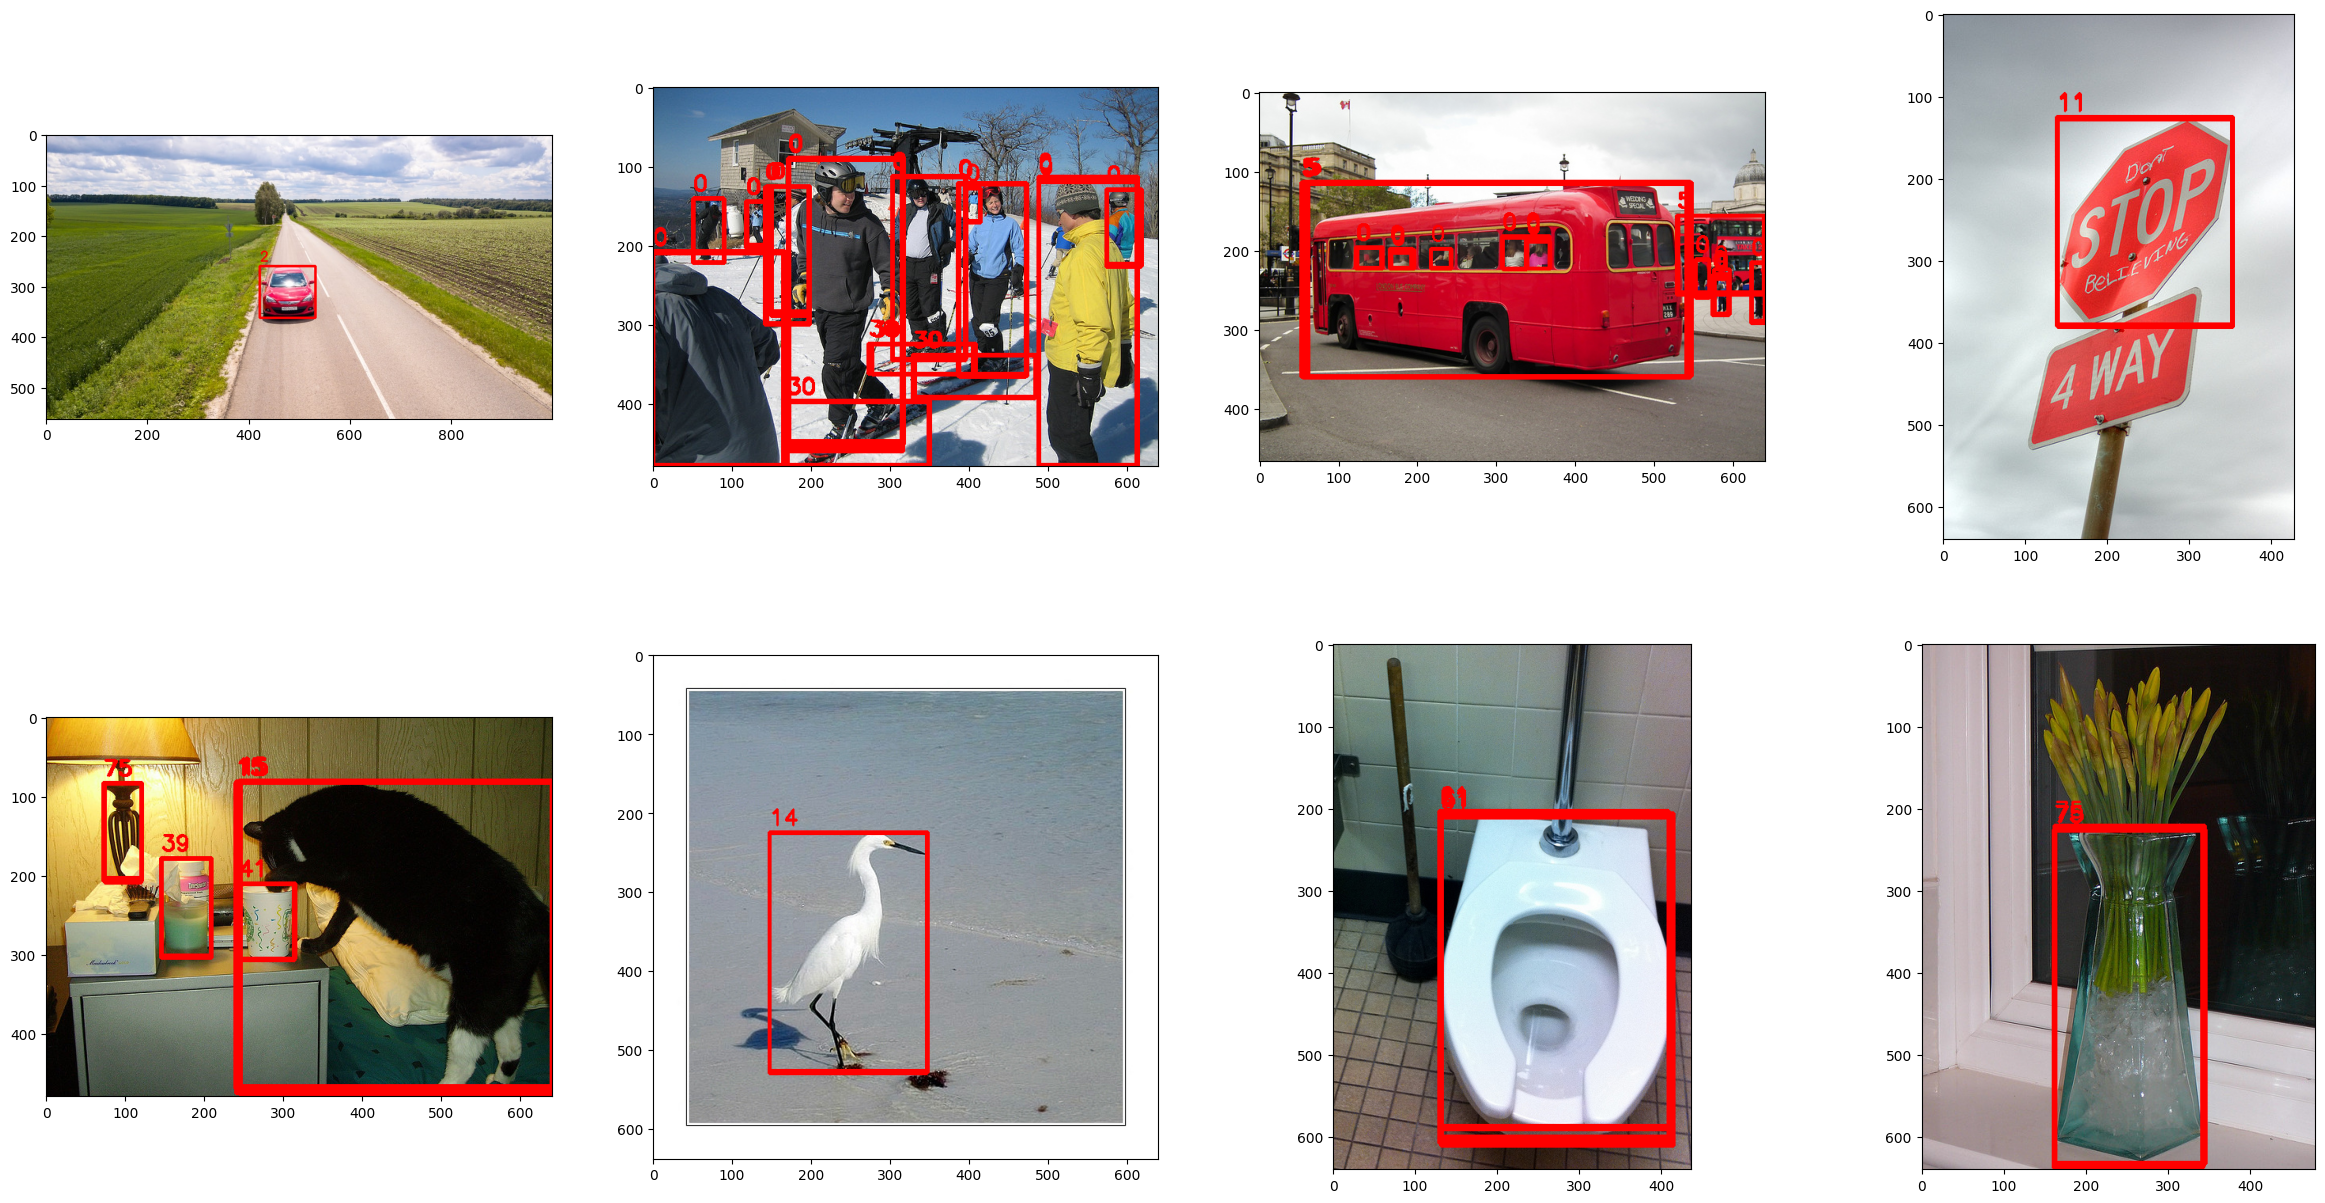

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(30, 15))
for i, answer_json in enumerate(answers):
    bboxs_json = json.loads(answer_json)
    image_bord = images[i].copy()
    for answer in bboxs_json:
        bbox = list(map(float, answer['bbox']))
        bbox = list(map(int, bbox))
        image_bord = cv2.rectangle(image_bord, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color=(255, 0, 0), thickness=3)
        image_bord = cv2.putText(image_bord, answer['class'], (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0 , 0), 2)
    axes[i%2][i//2].imshow(image_bord)
plt.show()